# Classification severity acne 5 level by Image Classification

( Using ResNet50V2 pre-trained model )

## Dataset
We use ACNE04 dataset for acne faces data

URL: https://github.com/xpwu95/LDL

And no acne faces data from Human Face Dataset

URL: https://www.kaggle.com/datasets/ashwingupta3012/human-faces

In [ ]:
import keras
keras.__version__

'2.15.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import os
# Paths for input and output folders
input_folder = "/content/drive/MyDrive/Acne04_New"
output_folder = "/content/drive/MyDrive/Acne04_Newclasscropped"

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Load the cascade
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/haarcascade_frontalface_default.xml')

# Iterate over all files in the input folder
for filename in os.listdir(input_folder):
    if filename.startswith("levle5"):
        # Read the input image
        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path)

        # Convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

        # Find the largest face
        largest_face = None
        largest_area = 0
        for (x, y, w, h) in faces:
            area = w * h
            if area > largest_area:
                largest_face = (x, y, w, h)
                largest_area = area

        # Crop the largest face and save it to the output folder
        if largest_face is not None:
            x, y, w, h = largest_face
            face_area = w * h
            img_area = img.shape[0] * img.shape[1]
            if face_area > 0.5 * img_area:
                face = img[y:y+h, x:x+w]
                output_path = os.path.join(output_folder, filename)
                cv2.imwrite(output_path, face)
            else:
                output_path = os.path.join(output_folder, filename)
                cv2.imwrite(output_path, img)

print("Cropped faces saved to", output_folder)

Cropped faces saved to /content/drive/MyDrive/Acne04_Newclasscropped


In [ ]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history):

    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['accuracy'][-1])
    print('Last validation accuracy: %s'%history.history['val_accuracy'][-1])

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    # Define a subplot
    fig, axs = plt.subplots(1,2,figsize=(15,4))

    # Plot loss
    loss_plot = axs[0]

    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()

    # Plot accuracy
    acc_plot = axs[1]

    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):

    # Calculate result
    result = model.evaluate(features,labels,verbose=False)

    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    labels = labels.argmax(axis=1)
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))

    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')

    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))

# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


def deprocess_image(img):

    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1

    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')

    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])

    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)

    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])

    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)

            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import pandas as pd
import glob
from PIL import Image
from zipfile import ZipFile

In [ ]:
# Extract the zip file
zip_file_path = '/content/drive/MyDrive/Acne04_New.zip'
extracted_folder_path = '/content/drive/MyDrive'

with ZipFile(zip_file_path, 'r') as zip_ref:
   zip_ref.extractall(extracted_folder_path)

In [ ]:
from PIL import Image
import os

def is_image_corrupted(file_path):
    try:
        # Attempt to open the image
        img = Image.open(file_path)
        img.verify()
        return False  # Image is not corrupted
    except (IOError, SyntaxError) as e:
        print(f"Corrupted image: {file_path} - {e}")
        return True  # Image is corrupted

def remove_corrupted_images(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if is_image_corrupted(file_path):
            try:
                # Remove the corrupted image
                os.remove(file_path)
                print(f"Removed corrupted image: {file_path}")
            except OSError as e:
                print(f"Error removing corrupted image: {file_path} - {e}")
# Specify the directory containing your images
image_directory = '/content/drive/MyDrive/Acne04_New'

# Remove corrupted images from the specified directory
remove_corrupted_images(image_directory)

In [ ]:
image_dir = "/content/drive/MyDrive/Acne04_New"

filenames = os.listdir(image_dir)
labels = [x.split("levle")[1].split("_")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})

data.head()

,filename,label
0,levle1_153.jpg,1
1,levle1_154.jpg,1
2,levle1_155.jpg,1
3,levle1_156.jpg,1
4,levle1_157.jpg,1


In [ ]:
# Define the label mapping
label_mapping = {'0': '1', '1': '2', '2': '3', '3': '4', '5': '0'}

# Replace labels in the DataFrame
data["label"] = data["label"].replace(label_mapping)

In [ ]:
label_counts = data['label'].value_counts()
print(label_counts)

2    637
1    497
3    186
4    137
0    100
Name: label, dtype: int64


# Data Preparation



In [ ]:
data

,filename,label
0,levle1_153.jpg,2
1,levle1_154.jpg,2
2,levle1_155.jpg,2
3,levle1_156.jpg,2
4,levle1_157.jpg,2
...,...,...
1552,levle1_149.jpg,2
1553,levle1_15.jpg,2
1554,levle1_150.jpg,2
1555,levle1_151.jpg,2


In [ ]:
#Split the data
labels = data['label']

X_train, X_temp = train_test_split(data, test_size=0.4, stratify=labels, random_state = 42)

label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (934, 2)
The shape of test data (311, 2)
The shape of validation data (312, 2)


In [ ]:
label_counts = X_train['label'].value_counts()
print(label_counts)

2    382
1    298
3    112
4     82
0     60
Name: label, dtype: int64


In [ ]:
label_counts = X_temp['label'].value_counts()
print(label_counts)

2    255
1    199
3     74
4     55
0     40
Name: label, dtype: int64


In [ ]:
# parameters
image_size = 224
image_channel = 3
bat_size = 32

In [ ]:
# Create image data generator
train_idg = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_idg = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_idg.flow_from_dataframe(X_train,
                                                    directory = '/content/drive/MyDrive/Acne04_New',
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size),
                                                    # save_to_dir="/content/drive/MyDrive/imggen/",
                                                    # save_prefix="", save_format='png'
                                                   )
val_generator = test_idg.flow_from_dataframe(X_val,
                                                 directory = '/content/drive/MyDrive/Acne04_New',
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )

test_generator = test_idg.flow_from_dataframe(X_test,
                                                  directory = '/content/drive/MyDrive/Acne04_New',
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )

Found 934 validated image filenames belonging to 5 classes.
Found 312 validated image filenames belonging to 5 classes.
Found 311 validated image filenames belonging to 5 classes.


# Train Model

In [ ]:
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [ ]:
from keras.applications import ResNet50V2

ResNet = ResNet50V2(include_top=False,
                  weights='imagenet',
                  input_shape=(224,224,3),
                  )
top_model = ResNet.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(4096, activation='relu')(top_model)
top_model = Dense(1072, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
output_layer = Dense(5, activation='softmax')(top_model)

model_ResNet = Model(inputs=ResNet.input, outputs=output_layer)
model_ResNet.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                             

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

In [ ]:
model_ResNet.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
batch = train_generator[0]
images, labels = batch

# Now you can inspect the batch
print("Shape of images batch:", images.shape)
print("Shape of labels batch:", labels.shape)

Shape of images batch: (32, 224, 224, 3)
Shape of labels batch: (32, 5)


In [ ]:
history2 = model_ResNet.fit(train_generator,
                    epochs = 30,
                    validation_data = val_generator,
                    callbacks=[learning_rate_reduction]
                   )


Epoch 1/30
 5/30 [====>.........................] - ETA: 29s - loss: 26.0996 - accuracy: 0.2500

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


30/30 [==============================] - 121s 3s/step - loss: 5.7292 - accuracy: 0.3694 - val_loss: 26.2743 - val_accuracy: 0.3365 - lr: 0.0010
Epoch 2/30
30/30 [==============================] - 78s 3s/step - loss: 1.3261 - accuracy: 0.3854 - val_loss: 6.3107 - val_accuracy: 0.4038 - lr: 0.0010
Epoch 3/30
30/30 [==============================] - 76s 3s/step - loss: 1.2001 - accuracy: 0.3887 - val_loss: 2.8004 - val_accuracy: 0.3974 - lr: 0.0010
Epoch 4/30
30/30 [==============================] - ETA: 0s - loss: 1.1903 - accuracy: 0.4540
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
30/30 [==============================] - 80s 3s/step - loss: 1.1903 - accuracy: 0.4540 - val_loss: 3.7530 - val_accuracy: 0.3173 - lr: 0.0010
Epoch 5/30
30/30 [==============================] - 80s 3s/step - loss: 1.0723 - accuracy: 0.4679 - val_loss: 2.1634 - val_accuracy: 0.4006 - lr: 5.0000e-04
Epoch 6/30
30/30 [==============================] - 75s 3s/step - loss: 1.0066 - 

Last train accuracy: 0.8265524506568909
Last validation accuracy: 0.7692307829856873


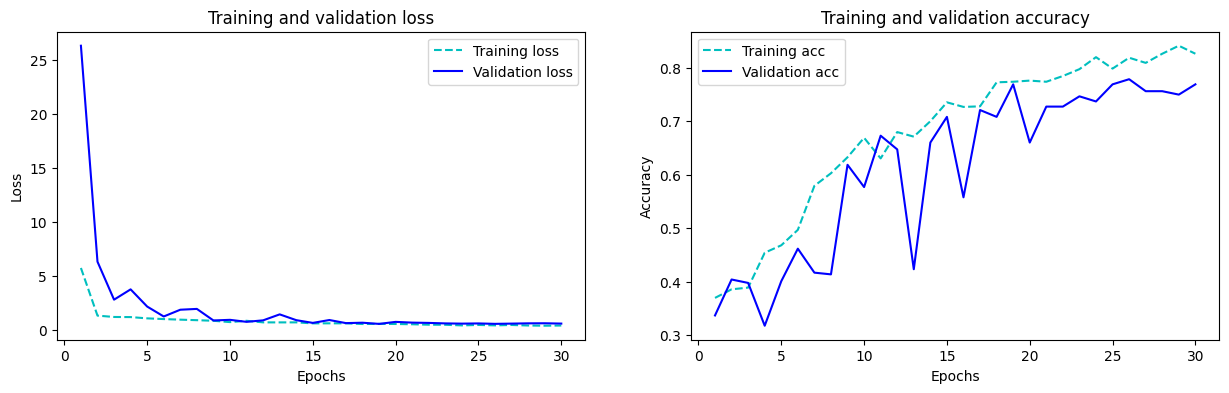

In [ ]:
show_result(history2)

In [ ]:
from keras.models import save_model

# Save the model to a file
model_saved = '/content/drive/MyDrive/Acne_model_V2.h5'
save_model(model_ResNet, model_saved)

# Now your TensorFlow model is saved to the specified directory


<ipython-input-32-2fd83d40afb7>:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_ResNet, model_saved)


# Evaluate Model

In [ ]:
from keras.models import load_model
from keras import backend as K
K.clear_session()
model_saved = '/content/drive/MyDrive/Acne_model_V2.h5'
loaded_model = load_model(model_saved)

In [ ]:
# Evaluvate for train generator
loss,acc = loaded_model.evaluate(train_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = loaded_model.evaluate(val_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


The accuracy of the model for training data is: 86.1884355545044
The Loss of the model for training data is: 0.34164759516716003
The accuracy of the model for validation data is: 76.92307829856873
The Loss of the model for validation data is: 0.5891887545585632


In [ ]:
for batch in train_generator:
    images, labels = batch
    print("Batch shape - Images:", images.shape, "Labels:", labels.shape)
    print("Sample Image:", images[0])
    print("Sample Label:", labels[0])
    break  # Break after printing the first batch to avoid a long output

In [ ]:
# prediction
result = loaded_model.predict(test_generator,batch_size = bat_size,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_generator.labels

# Evaluvate
loss,acc = loaded_model.evaluate(test_generator, batch_size = bat_size, verbose = 0)

labels =['0','1','2','3','4']
print(classification_report(y_true, y_pred,target_names=labels))

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.75      0.77      0.76        99
           2       0.69      0.76      0.73       127
           3       0.58      0.38      0.46        37
           4       0.80      0.71      0.75        28

    accuracy                           0.73       311
   macro avg       0.76      0.72      0.74       311
weighted avg       0.73      0.73      0.72       311

The accuracy of the model for testing data is: 72.9903519153595
The Loss of the model for testing data is: 0.6616420745849609


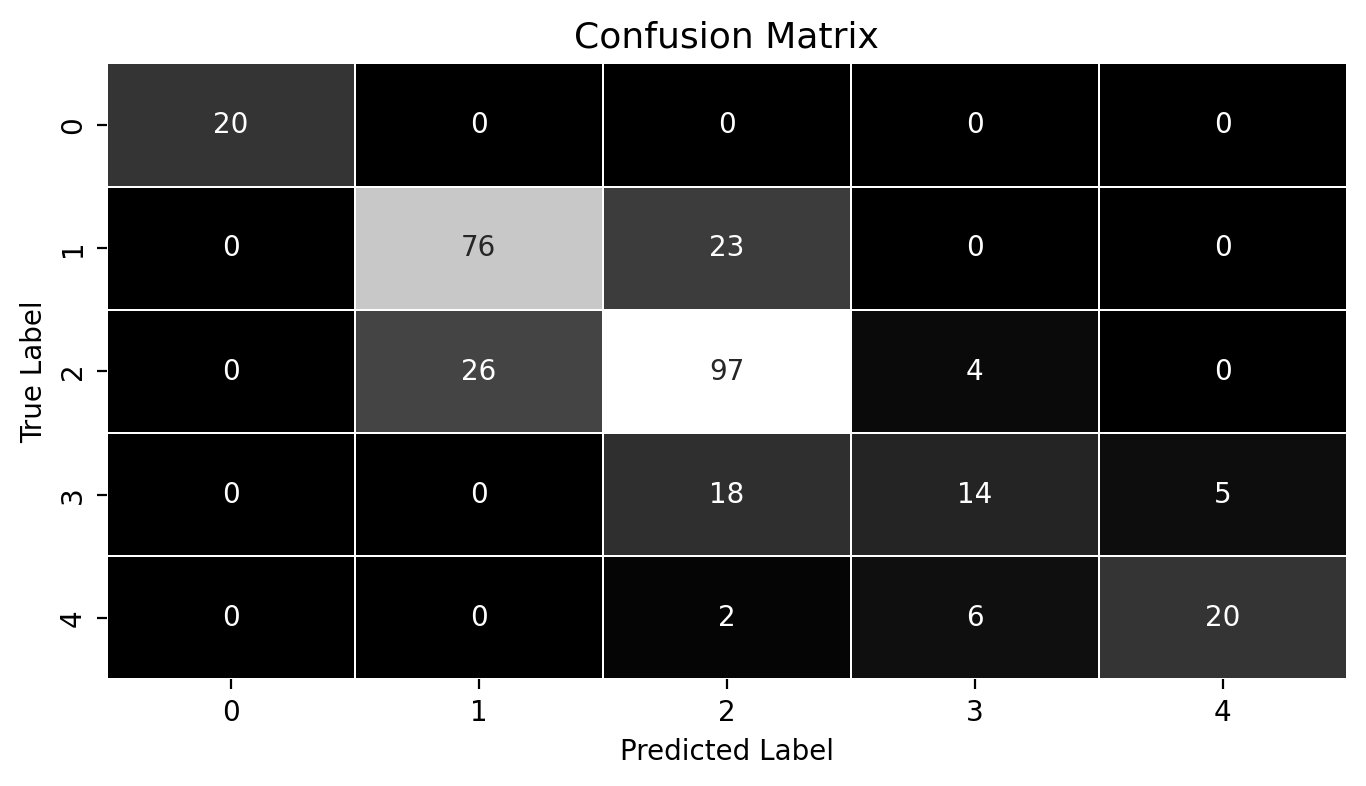

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Generate the confusion matrix
matrix = confusion_matrix(y_true, y_pred)

# Convert the values in the matrix to strings with a specific format
matrix_str = [[f'{value:.0f}' if value < 100 else f'{value:.1e}' for value in row] for row in matrix]

# Plot the heatmap with customized annotations
f, ax = plt.subplots(figsize=(8, 4), dpi=200)
sns.heatmap(matrix, annot=matrix_str, fmt='', linewidths=0.1, cmap="gist_yarg_r", ax=ax, cbar=False, xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label", fontsize=10)
plt.title("Confusion Matrix", fontsize=13)

plt.show()


1/1 [==============================] - 1s 1s/step


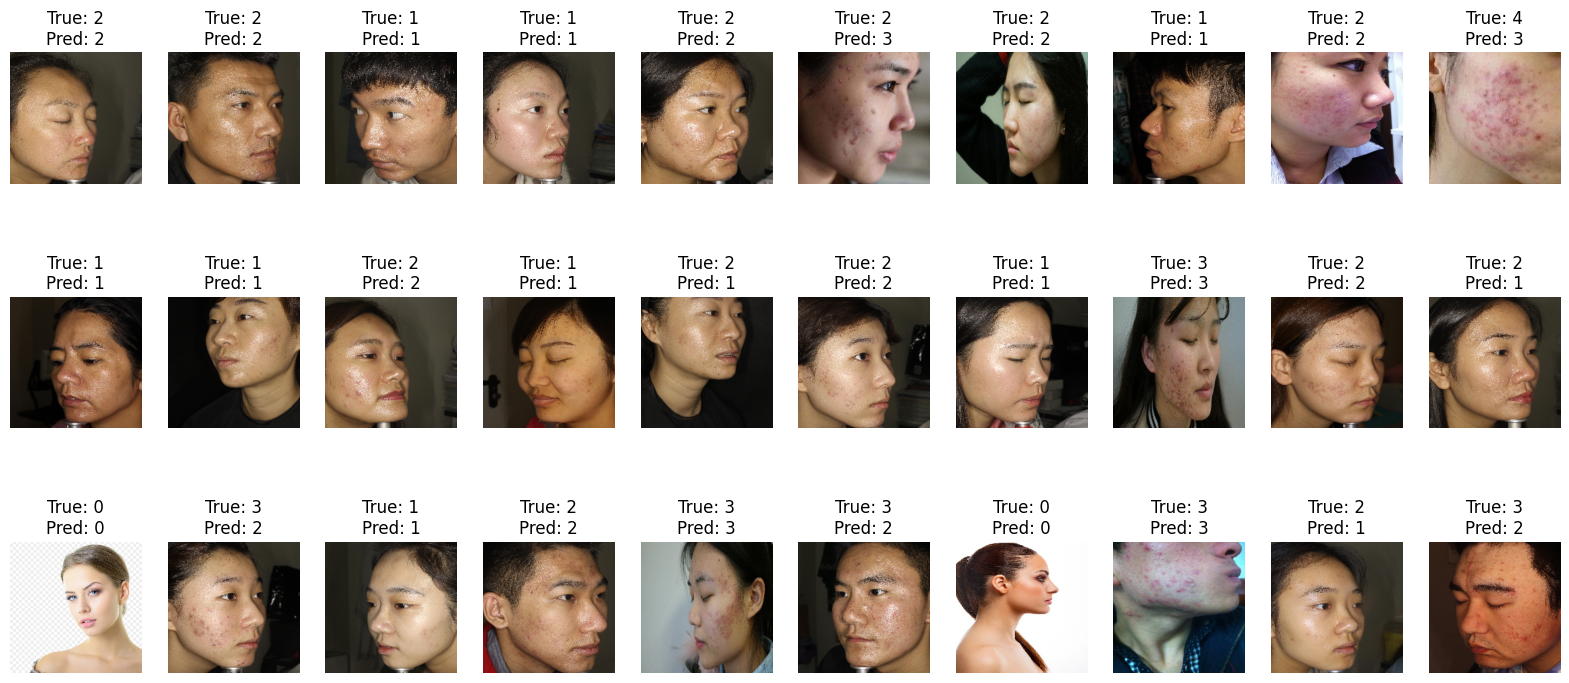

In [ ]:
import matplotlib.pyplot as plt

# Assuming test_generator contains the image data and labels
# Also, assuming that your loaded_model.predict returns probabilities for each class

# Get a batch of test data
batch_x, batch_y_true = test_generator.next()

# Make predictions on the batch
batch_y_pred_prob = loaded_model.predict(batch_x)

# Convert probabilities to class labels
batch_y_pred = np.argmax(batch_y_pred_prob, axis=1)

# If batch_y_true is one-hot encoded, convert it to class indices
if len(batch_y_true.shape) > 1:
    batch_y_true = np.argmax(batch_y_true, axis=1)

# Display images with true and predicted labels in three rows
num_images_to_display = len(batch_x)
num_rows = 3
num_images_per_row = num_images_to_display // num_rows

fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(20, 9))

for i in range(num_rows):
    for j in range(num_images_per_row):
        idx = i * num_images_per_row + j
        # Display the image
        axes[i, j].imshow(batch_x[idx])
        axes[i, j].axis('off')

        # Display the true and predicted labels
        true_label = labels[batch_y_true[idx]]
        pred_label = labels[batch_y_pred[idx]]
        title = f'True: {true_label}\nPred: {pred_label}'
        axes[i, j].set_title(title)

plt.show()


# Test model with other images outside dataset

1/1 [==============================] - 0s 23ms/step


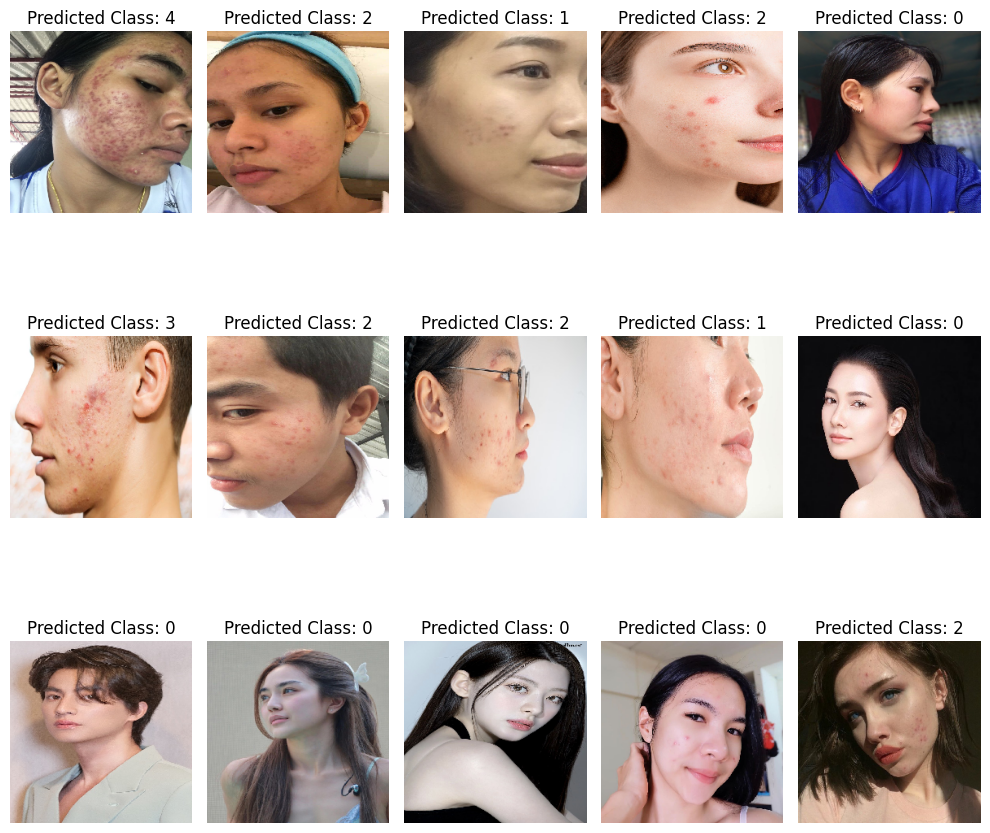

In [ ]:
import os
from keras.preprocessing import image
import numpy as np

# Define the folder path
folder_path = '/content/drive/MyDrive/testimg'

# Get a list of all files in the folder
file_list = os.listdir(folder_path)

# Create a figure to plot the images
fig = plt.figure(figsize=(10, 10))

# Loop through each file in the folder
for i, file_name in enumerate(file_list):
    # Load and preprocess the image
    img = image.load_img(os.path.join(folder_path, file_name), target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize the pixel values

    # Expand dimensions to create a batch of one image
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class
    predictions = loaded_model.predict(img_array)
    predicted_class = np.argmax(predictions)

    # Plot the image with the predicted class label
    ax = fig.add_subplot(3, 5, i+1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Predicted Class: {predicted_class}')

# Show the plot
plt.tight_layout()
plt.show()
